In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import pymc as pm
import scipy as sp
import pickle
from sklearn.preprocessing import MinMaxScaler, minmax_scale, scale, robust_scale
import patsy as pt
import arviz as az

In [8]:
def gamma(alpha, beta):
    def g(x):
        return pm.Gamma(x, alpha=alpha, beta=beta)
    return g

def hcauchy(beta):
    def g(x):
        return pm.HalfCauchy(x, beta=beta)
    return g


def fit_gp(y, X, l_prior, eta_prior, sigma_prior, nu_prior=None, kernel_type='M52', 
           bayes_kws=dict(draws=1000, tune=1000, chains=2, cores=1), prop_Xu=None, 
           model_type='marginal', noise_model='normal', n_ppc=0):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use. If None, use full marginal likelihood. If not none, use FTIC. 
    bayes_kw : kws for pm.sample
    X, y are dataframes. We'll use the column names. 
    """
    kernel_type = kernel_type.lower()
    with pm.Model() as model:
        # Covert arrays
        X_a = X.values
        y_a = y.values.flatten()
        X_cols = list(X.columns)

        
        # Kernels
        # 3 way interaction
        eta = eta_prior('eta')
        cov = eta**2
        for i in range(X_a.shape[1]):
            var_lab = 'l_'+X_cols[i]
            if kernel_type=='rbf':
                cov = cov*pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='exponential':
                cov = cov*pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='m52':
                cov = cov*pm.gp.cov.Matern52(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='m32':
                cov = cov*pm.gp.cov.Matern32(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])

        # Covariance model
        cov_tot = cov 
        
        sigma_n =sigma_prior('sigma_n')

        # Model
        if model_type=='latent': 
            gp = pm.gp.Latent(cov_func=cov_tot)
            f = gp.prior("f", X=X_a)
            if noise_model == 'normal':
                y_ = pm.Normal("y_", mu=f, sigma=sigma_n, observed=y_a)
            elif noise_model == 'TP': 
                nu = nu_prior('nu')
                y_ = pm.StudentT("y", mu=f, lam=1.0 / sigma_n, nu=nu, observed=y_a)
            else:
                raise ValueError('must specify noise for latent model')
                
        elif model_type=='TP':
            nu1 = nu_prior('nu1')
            tp = pm.gp.TP(cov_func=cov_tot, nu=nu1)
            f = tp.prior("f", X=X_a)
            
            if noise_model == 'normal':
                y_ = pm.Normal("y_", mu=f, sigma=sigma_n, observed=y_a)
            elif noise_model == 'TP': 
                nu2 = nu_prior('nu2')
                y_ = pm.StudentT("y", mu=f, lam=1.0 / sigma_n, nu=nu2, observed=y_a)
            else:
                raise ValueError('must specify noise for TP model')            
            
            gp = tp
            
        elif model_type=='marginal':
            # Noise model

            if not (prop_Xu is None):
                # Inducing variables
                num_Xu = int(X_a.shape[0]*prop_Xu)
                Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X_a)
                gp = pm.gp.MarginalSparse(cov_func=cov_tot, approx="FITC")
                y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a, Xu=Xu, noise=sigma_n)
            else:
                gp = pm.gp.Marginal(cov_func=cov_tot)
                y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a, noise=sigma_n)
            
        if n_ppc > 0: 
            result = pm.sample_prior_predictive(samples=n_ppc)
        else:
            if not (bayes_kws is None):
                trace = pm.sample(**bayes_kws)
                result = trace
            else:
                mp = pm.find_MAP()
                result = mp
    
    return gp, result, model




def scale_df(df, feature_range=(-5, 5)):
    new_df = []
    
    for col in df.columns: 
        x = df[col].values.reshape(-1, 1)
        if col == 'ts': 
            x = robust_scale(np.log(x))
        elif col == 'vamp2_eq':
            x = robust_scale(x)
        elif col == 'hp_ix': 
            pass
        elif col in ['dim', 'lag', 'steep', 'cent', 'states']: 
            x = minmax_scale(x, feature_range=feature_range)
        else: 
            pass

        new_df.append(pd.Series(x.flatten(), name=col))
            
    new_df = pd.concat(new_df, axis=1)
    return new_df
    
    

In [9]:
protein = '1fme'
lag=41
proc=2


params = [['dihedrals', None], ['distances', 'linear'], ['distances', 'logistic']]
kernels = ['exponential', 'rbf', 'm32', 'm52']

# pre-processing params
data_cols = ['median', 'tica__dim', 'tica__lag', 'cluster__k', 'feature__value', 'distances__scheme', 'distances__transform', 
             'distances__steepness', 'distances__centre'
]
var_names_short = ['ts', 'dim', 'lag', 'states', 'feat', 'scheme', 'trans', 'steep', 'cent']
name_dict = dict(zip(data_cols, var_names_short))
scaling = dict(dim=[1, 20], lag=[1, 100],states=[10, 500], steep=[0, 50], cent=[0, 1.5])

# Bayesian kws
bayes_kws = dict(draws=1000, tune=1000, chains=4, cores=4, target_accept=0.90)

# Load data
summary_path = f'{protein}/summary.h5'
hp_path = '../experiments/hpsample.h5'
timescales = pd.read_hdf(summary_path, key='timescales')
vamps = pd.read_hdf(summary_path, key='vamps')
timescales.reset_index(inplace=True)
vamps.reset_index(inplace=True)
hps = pd.read_hdf(hp_path)
hps.reset_index(inplace=True)

# Create main data DF
data = timescales.query(f"process=={proc}").query(f'lag=={lag}')
data = data.merge(hps, on=['hp_ix'], how='left')
data = data.loc[:, data_cols+['hp_ix']]
data.rename(mapper=name_dict, axis=1, inplace=True)

# Add GMRQ from timescale: 

data['vamp2_eq'] = 1+np.exp(-lag/data['ts'])**2


HDF5ExtError: HDF5 error back trace

  File "H5F.c", line 620, in H5Fopen
    unable to open file
  File "H5VLcallback.c", line 3502, in H5VL_file_open
    failed to iterate over available VOL connector plugins
  File "H5PLpath.c", line 579, in H5PL__path_table_iterate
    can't iterate over plugins in plugin path '(null)'
  File "H5PLpath.c", line 620, in H5PL__path_table_iterate_process_path
    can't open directory: /Users/robertarbon/opt/miniconda3/envs/pymc/lib/hdf5/plugin
  File "H5VLcallback.c", line 3351, in H5VL__file_open
    open failed
  File "H5VLnative_file.c", line 97, in H5VL__native_file_open
    unable to open file
  File "H5Fint.c", line 1990, in H5F_open
    unable to read superblock
  File "H5Fsuper.c", line 405, in H5F__super_read
    file signature not found

End of HDF5 error back trace

Unable to open/create file '1fme/summary.h5'

In [16]:
!ls -lah 1fme

total 590600
drwxrwxr-x@ 12 robertarbon  staff   384B 24 May 10:03 .
drwxrwxr-x@ 32 robertarbon  staff   1.0K 24 May 14:00 ..
drwxrwxr-x@  4 robertarbon  staff   128B 19 May 18:09 .ipynb_checkpoints
-rw-r--r--@  1 robertarbon  staff    22K 24 May 11:19 1fme_timescales.pdf
-rw-r--r--   1 robertarbon  staff    11K 17 May 15:05 1fme_timescales.png
-rw-r--r--   1 robertarbon  staff    23K 17 May 14:51 BBA_timescale_gradient.pdf
drwxr-xr-x   3 robertarbon  staff    96B  5 Apr 11:30 hp_235
drwxr-xr-x   3 robertarbon  staff    96B  5 Apr 11:31 hp_24
-rw-r--r--   1 robertarbon  staff   288M 17 May 14:18 raw.h5
drwxr-xr-x  28 robertarbon  staff   896B 24 May 09:28 sensitivity
-rw-r--r--   1 robertarbon  staff    16K 24 May 08:28 sensitivity.pdf
-rw-r--r--   1 robertarbon  staff   132B 24 May 10:03 summary.h5


In [10]:
import h5py 
with h5py.File('1fme/summary.h5') as f: 
    print(f.keys())

OSError: Unable to open file (file signature not found)

In [3]:


# Scale data
data_s = scale_df(data, feature_range=(-9, 2))

out_dir = Path(protein).joinpath('sensitivity', 'timescales')
out_dir.mkdir(parents=True, exist_ok=True)

for kernel in ['exponential']: 
    print(kernel)
    for feat, trans in params:
        print(feat, trans)
        
        out_path = out_dir.joinpath(f"{feat}_{trans}_{kernel}_mml.pkl")

        # Create formula
        formula = "vamp2_eq ~  dim + lag + states"
        if feat == 'distances': 
            formula += ' + scheme'
            if (trans == 'logistic'): 
                formula += " + steep + cent"
        print(formula)

        # Create subsetted DF
        X = data_s.query(f"(feat == '{feat}')")
        if trans is not None: 
            X = X.query(f"trans == '{trans}'")

        ydf, Xdf = pt.dmatrices(formula, data=X, return_type='dataframe', NA_action='raise')
        Xdf.drop(labels=['Intercept'], axis=1, inplace=True)

        # Fit model
        l_prior = gamma(2, 0.5)
        eta_prior = hcauchy(2)
        sigma_prior = hcauchy(2)
        nu_prior = gamma(2, 0.05)
        gp, trace, model = fit_gp(y=ydf, X=Xdf,  # Data
                                        l_prior=l_prior, eta_prior=eta_prior, sigma_prior=sigma_prior,  # Priors
                                        kernel_type=kernel,  # Kernel
                                        prop_Xu=None,  # proportion of data points which are inducing variables.
                                        bayes_kws=None, model_type='marginal', noise_model=None, nu_prior=None)  # Bayes kws

        with model: 
            y_pred, var = gp.predict(Xdf.values,point=trace, diag=True)

        rmse = np.sqrt(np.sum((ydf.values.flatten()-y_pred)**2))

        results = {'trace': trace, 'data': pd.concat([ydf,Xdf], axis=1), 'formula': formula, 'lag': lag, 'proc': proc}


        pickle.dump(obj=results, file=out_path.open('wb'))

        with sns.plotting_context('paper'):
            plt.scatter(ydf.values, y_pred)
            plt.title(f"rmse: {rmse:4.2f}")
            plt.ylim(-9, 9)
            plt.xlim(-9, 9)
            plt.plot([-9, 9], [-9, 9])
            plt.xlabel('observed values')
            plt.ylabel('predicted values')

            plt.savefig(out_path.with_suffix('.pdf'), bbox_inches='tight')
            plt.close()

HDF5ExtError: HDF5 error back trace

  File "H5F.c", line 620, in H5Fopen
    unable to open file
  File "H5VLcallback.c", line 3502, in H5VL_file_open
    failed to iterate over available VOL connector plugins
  File "H5PLpath.c", line 579, in H5PL__path_table_iterate
    can't iterate over plugins in plugin path '(null)'
  File "H5PLpath.c", line 620, in H5PL__path_table_iterate_process_path
    can't open directory: /Users/robertarbon/opt/miniconda3/envs/pymc/lib/hdf5/plugin
  File "H5VLcallback.c", line 3351, in H5VL__file_open
    open failed
  File "H5VLnative_file.c", line 97, in H5VL__native_file_open
    unable to open file
  File "H5Fint.c", line 1990, in H5F_open
    unable to read superblock
  File "H5Fsuper.c", line 405, in H5F__super_read
    file signature not found

End of HDF5 error back trace

Unable to open/create file '1fme/summary.h5'

In [4]:
!pwd

/Users/robertarbon/Documents/Research/msm_sensitivity_analysis/analysis


prior predictive checks

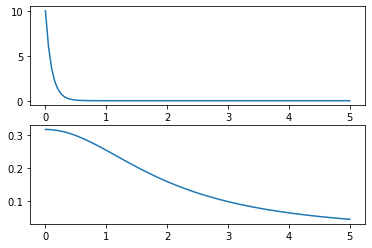

In [27]:
x = np.linspace(0, 5, 100)
fig, ax = plt.subplots(2)

pdf1 = pm.Gamma.dist(1, 10)
ax[0].plot(x, np.exp(pm.logp(pdf1, x).eval()))
pdf2 = pm.HalfCauchy.dist(2)
ax[1].plot(x, np.exp(pm.logp(pdf2, x).eval()))

In [6]:
l_prior = gamma(2, 0.5)
eta_prior = hcauchy(2)
sigma_prior = hcauchy(2)
kernel='exponential'
trans = 'logistic'
feat = 'distances'

# Create formula
formula = "vamp2_eq ~  dim + lag + states"
if feat == 'distances': 
    formula += ' + scheme'
    if (trans == 'logistic'): 
        formula += " + steep + cent"
print(formula)
data_s = scale_df(data, feature_range=(-9, 2))

# Create subsetted DF
X = data_s.query(f"(feat == '{feat}')")
if trans is not None: 
    X = X.query(f"trans == '{trans}'")

    
ydf, Xdf = pt.dmatrices(formula, data=X, return_type='dataframe', NA_action='raise')
Xdf.drop(labels=['Intercept'], axis=1, inplace=True)

ix = ydf.values > np.quantile(ydf.values, 0.9)
ydf = ydf.loc[ix, :]
Xdf = Xdf.loc[ix, :]

gp, mp, model = fit_gp(y=ydf, X=Xdf,  # Data
                                l_prior=l_prior, eta_prior=eta_prior, sigma_prior=sigma_prior,  # Priors
                                kernel_type=kernel,  # Kernel
                                prop_Xu=None,  # proportion of data points which are inducing variables.
                                bayes_kws=None, model_type='marginal', 
                          noise_model=None, nu_prior=None, 
                         n_ppc=0)  # Bayes kws
with model: 
    y_pred, var = gp.predict(Xdf.values,point=mp, diag=True)

    rmse = np.sqrt(np.sum((ydf.values.flatten()-y_pred)**2))

with sns.plotting_context('paper'):
    plt.scatter(ydf.values, y_pred)
    plt.title(f"rmse: {rmse:4.2f}")
    plt.ylim(-9, 9)
    plt.xlim(-9, 9)
    plt.plot([-9, 9], [-9, 9])
    plt.xlabel('observed values')
    plt.ylabel('predicted values')
print(mp['l_cent'], mp['l_steep'], mp['l_states'])

vamp2_eq ~  dim + lag + states + scheme + steep + cent


NameError: name 'data' is not defined

3.9977005731527187


0.09756578947368422


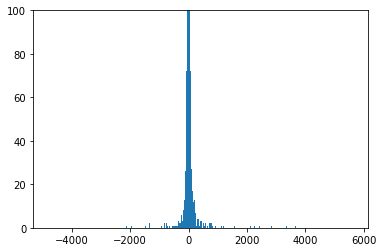

In [129]:
_ = plt.hist(np.array(ppc.prior_predictive['y_']).flatten(), bins=1000)

plt.ylim(0, 100)
    
print(np.mean(np.abs(np.array(ppc.prior_predictive['y_']).flatten())>10))
# plt.xlim(-10, 10)